# Setup Imports

In [85]:
# Setup
import pvlib
from pvlib.pvsystem import PVSystem, Array, FixedMount
from pvlib.location import Location
from pvlib.modelchain import ModelChain
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from userdefinedmodels import *
import solarpanels

# Setup Location and Weather

In [86]:
# evaluate hood river, oregon and key west, florida

# latitude, longitude, name, altitude, timezone
hood_river = (45.71417626139969, -121.5154782530592, 'Hood River', 27, 'Etc/GMT+8')
latitude, longitude, name, altitude, timezone = hood_river

location = Location(
    latitude,
    longitude,
    name=name,
    altitude=altitude,
    tz=timezone,
    )

times = pd.date_range('2019-07-24 00:00', '2019-07-24 23:59', freq='1s', tz=location.tz)
weather = location.get_clearsky(times)




## Sunrise Data

In [87]:
# Get the date
date = pd.Timestamp(times[0].date()).tz_localize(location.tz)

# Create a DatetimeIndex with the single date
times_single_day = pd.DatetimeIndex([date])

# Get sunrise, sunset, and transit times for the date
result = location.get_sun_rise_set_transit(times_single_day)

# Print the sunrise time
print(type(result))

# Get sunrise, sunset, and transit times from the DataFrame
sunrise = result['sunrise'].iloc[0]
sunset = result['sunset'].iloc[0]
transit = result['transit'].iloc[0]

# Print the sunrise time
print(sunrise)


<class 'pandas.core.frame.DataFrame'>
2019-07-24 04:39:48.138688-08:00


# Setup System

## Module Parameters

In [88]:
rich_solar_12V_params = solarpanels.get_rich_solar_MEGA200_12V()

## Temperature Parameters

In [89]:
temperature_model_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']


## Inverter Parameters
For this evaluation use ideal parameters (perfect efficiency, no ohmic loss or voltage drop)

In [90]:

r_batt_wire = 0
r_pv_wire = 0
mppt_eff = 1.0

mppt_parameters = {
    'v_batt': 14.4,
    'v_start_delta': 5.0,
    'v_continue_delta': 1.0,
    'r_batt_wire': r_batt_wire,
    'r_pv_wire': r_pv_wire,
    'mppt_eff': mppt_eff
}

In [91]:

mount = FixedMount(
    surface_tilt=0,
    surface_azimuth=180,
    )
array = Array(
    mount=mount,
    module_parameters=rich_solar_12V_params,
    temperature_model_parameters=temperature_model_parameters,
    strings=1,
    modules_per_string=1,
    )

system = PVSystem(arrays=[array], 
                  inverter_parameters=mppt_parameters)

mc = ModelChain(system, 
                location, 
                aoi_model="physical", 
                spectral_model="no_loss", 
                dc_model="cec",
                ac_model=mppt,
                dc_ohmic_model=pv_wire_loss
                )
mc.run_model(weather)

ModelChain: 
  name: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: cec
  ac_model: functools.partial(<function mppt at 0xffff49040900>, ModelChain: 
  name: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: cec
  ac_model: ...
  aoi_model: physical_aoi_loss
  spectral_model: no_spectral_loss
  temperature_model: sapm_temp
  losses_model: no_extra_losses)
  aoi_model: physical_aoi_loss
  spectral_model: no_spectral_loss
  temperature_model: sapm_temp
  losses_model: no_extra_losses

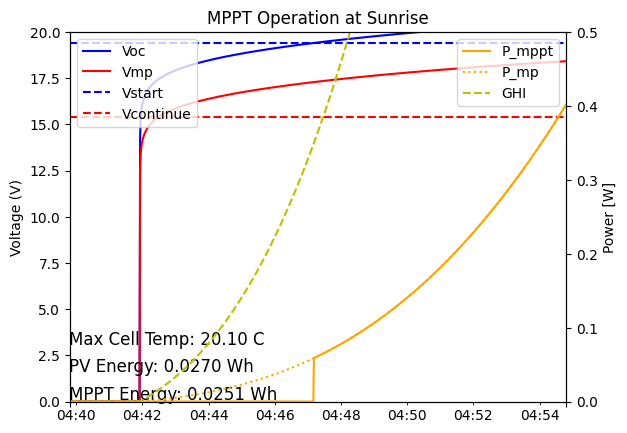

In [96]:
# Create a time delta of 15 minutes
delta = pd.Timedelta(minutes=15)
offset = pd.Timedelta(minutes=2)

# Calculate the start and end of the range
#start = sunrise + offset - delta
#end = sunrise 
start = sunrise - offset
start = sunrise
end = sunrise + delta

# Slice the DataFrame
ac_slice = mc.results.ac.loc[start:end]
dc_slice = mc.results.dc.loc[start:end]
irradiance_slice = mc.results.effective_irradiance.loc[start:end]
max_cell_temp = mc.results.cell_temperature.loc[start:end].max()


# Create a plot of the sliced DataFrame
fig, ax = plt.subplots()

# Plot v_oc and v_mp with specified colors and labels
dc_slice['v_oc'].plot(ax=ax, color='b', label='Voc')
dc_slice['v_mp'].plot(ax=ax, color='r', label='Vmp')

plt.title('MPPT Operation at Sunrise')

# Plot a vertical line at sunrise with a specified label
#ax.axvline(sunrise, color='g', linestyle='--', label='Sunrise')

# Plot a horizontal v_start and v_continue with a specified label
ax.axhline(mppt_parameters['v_batt'] + mppt_parameters['v_start_delta'], color='b', linestyle='--', label='Vstart')
ax.axhline(mppt_parameters['v_batt'] + mppt_parameters['v_continue_delta'], color='r', linestyle='--', label='Vcontinue')

# get max cell temerature

#calculate delta in over that period
dc_energy = dc_slice['p_mp'].sum()/3600
mppt_energy = ac_slice.sum()/3600

# add text to plot to show energy
plt.text(sunrise, 3.1, f"Max Cell Temp: {max_cell_temp:.2f} C", fontsize=12)
plt.text(sunrise, 1.6, f"PV Energy: {dc_energy:.4f} Wh", fontsize=12)
plt.text(sunrise, 0.1, f"MPPT Energy: {mppt_energy:.4f} Wh", fontsize=12)

# label the first y axis
ax.set_ylabel('Voltage (V)')

# Create a second Axes object that shares the x-axis with the first
ax2 = ax.twinx()

# Plot the power on the second Axes with a specified color and label
ac_slice.plot(ax=ax2, color='orange', label='P_mppt')
dc_slice['p_mp'].plot(ax=ax2, color='orange', label='P_mp', linestyle=':')

# Plot GHI on the second Axes with a specified color and label
irradiance_slice.plot(ax=ax2, color='y', label='GHI', linestyle='--')

# Add a label to the second y-axis
ax2.set_ylabel('Power [W]')

# Add a legend to each Axes
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

# Set the y-axis limits for each Axes
ax2.set_ylim(0, 0.5)
ax.set_ylim(0, 20)

# Show the plot
plt.show()
